In [ ]:
import torch
import torch.nn as nn
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def modify_data(path, key, mem_n):
    data = scio.loadmat(path)
    data_x = data['sig_x' + str(key)]
    data_y = data['sig_y' + str(key)]
    L = len(data_x)
    data_x_temp = np.pad(data_x, ((0, mem_n), (0, 0)), 'wrap').T
    data_x_temp_real = np.real(data_x_temp)
    data_x_temp_imag = np.imag(data_x_temp)
    data_x_new_real = np.zeros([L, mem_n])
    data_x_new_imag = np.zeros([L, mem_n])
    for i in range(L):
        data_x_new_real[i, :] = data_x_temp_real[:, i:mem_n+i]
        data_x_new_imag[i, :] = data_x_temp_imag[:, i:mem_n+i]

    data_y_real = np.real(data_y)
    data_y_imag = np.imag(data_y)
    return data_x_new_real, data_x_new_imag, data_y_real, data_y_imag


def train(epochs, model, x_train, y_train, criterion, optimizer, device):
    train_loss = []
    for i in range(epochs):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = model.forward(x_train)
        loss = criterion(y_pred, y_train)
        train_loss.append(loss.item())
        if i % 10 == 0:
            print(f'Epoch: {i} Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 绘图代码
    plt.plot(np.arange(len(train_loss)), train_loss, label="train loss")
    plt.legend()  # 显示图例
    plt.xlabel('epoches')
    plt.title('loss')
    plt.show()

    return model


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(40, 46)
        self.act1 = nn.Tanh()
        self.linear2 = nn.Linear(46, 30)
        self.act2 = nn.Tanh()
        self.linear3 = nn.Linear(30, 24)
        self.act3 = nn.Tanh()
        self.linear4 = nn.Linear(24, 16)
        self.act4 = nn.PReLU(16)
        self.output = nn.Linear(16, 1)

    # 前向传播
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        x = self.act3(x)
        x = self.linear4(x)
        x = self.act4(x)
        x = self.output(x)
        return x

: 

Epoch: 0 Loss: 4.811054229736328
Epoch: 10 Loss: 0.7465019226074219
Epoch: 20 Loss: 0.10530786216259003
Epoch: 30 Loss: 0.043603744357824326
Epoch: 40 Loss: 0.024643756449222565
Epoch: 50 Loss: 0.013661480508744717
Epoch: 60 Loss: 0.01133259292691946
Epoch: 70 Loss: 0.009779059328138828
Epoch: 80 Loss: 0.008833632804453373
Epoch: 90 Loss: 0.008119518868625164
Epoch: 100 Loss: 0.007502779830247164
Epoch: 110 Loss: 0.006985560990869999
Epoch: 120 Loss: 0.0065204002894461155
Epoch: 130 Loss: 0.00611359067261219
Epoch: 140 Loss: 0.005733857396990061
Epoch: 150 Loss: 0.005383078940212727
Epoch: 160 Loss: 0.005046089645475149
Epoch: 170 Loss: 0.004736011382192373
Epoch: 180 Loss: 0.004458324518054724
Epoch: 190 Loss: 0.004144093953073025


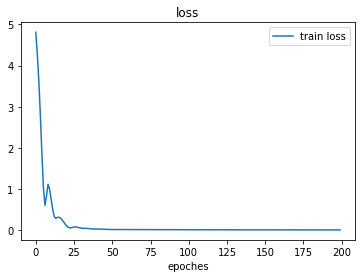

Epoch: 0 Loss: 4.667092800140381
Epoch: 10 Loss: 0.6187670826911926
Epoch: 20 Loss: 0.09430602937936783
Epoch: 30 Loss: 0.04498101770877838
Epoch: 40 Loss: 0.01913139969110489
Epoch: 50 Loss: 0.013924655504524708
Epoch: 60 Loss: 0.011041229590773582
Epoch: 70 Loss: 0.00966459047049284
Epoch: 80 Loss: 0.008640448562800884
Epoch: 90 Loss: 0.007933473214507103
Epoch: 100 Loss: 0.007330181077122688
Epoch: 110 Loss: 0.006868056952953339
Epoch: 120 Loss: 0.006466446444392204
Epoch: 130 Loss: 0.006108578760176897
Epoch: 140 Loss: 0.005790522322058678
Epoch: 150 Loss: 0.005511462222784758
Epoch: 160 Loss: 0.005266375839710236
Epoch: 170 Loss: 0.005055631045252085
Epoch: 180 Loss: 0.00487356074154377
Epoch: 190 Loss: 0.004712273832410574


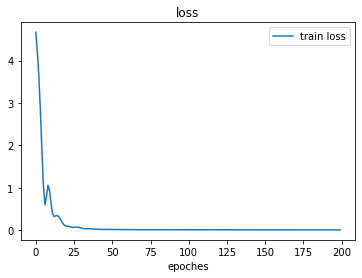

10


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mem_n = 40

# 10个不同PRBS
for PRBS_N in range(1):
    model_real = Model().to(device)
    model_imag = Model().to(device)
    loss_real = nn.MSELoss()
    loss_imag = nn.MSELoss()

    optimizer_real = torch.optim.Adam(model_real.parameters(), lr=0.01)
    optimizer_imag = torch.optim.Adam(model_imag.parameters(), lr=0.01)

    [X_real, X_imag, Y_real, Y_imag] = modify_data(
        'data/data_diffPRBS.mat', '_prbs'+str(PRBS_N+4), mem_n)

    X_train_real, X_test_real, Y_train_real, Y_test_real = train_test_split(
        X_real, Y_real, test_size=0.4, random_state=42)
    X_train_imag, X_test_imag, Y_train_imag, Y_test_imag = train_test_split(
        X_imag, Y_imag, test_size=0.4, random_state=42)

    x_train_real = torch.FloatTensor(X_train_real)
    y_train_real = torch.FloatTensor(Y_train_real)
    x_train_imag = torch.FloatTensor(X_train_imag)
    y_train_imag = torch.FloatTensor(Y_train_imag)

    model_real = train(200, model_real, x_train_real,
                       y_train_real, loss_real, optimizer_real, device)
    model_imag = train(200, model_imag, x_train_imag,
                       y_train_imag, loss_imag, optimizer_imag, device)
    
    x_test_real = torch.FloatTensor(X_test_real)
    y_test_real = torch.FloatTensor(Y_test_real)
    x_test_imag = torch.FloatTensor(X_test_imag)
    y_test_imag = torch.FloatTensor(Y_test_imag)

    Y_pred_real = []
    Y_pred_imag = []
    with torch.no_grad():
        x_test = x_test_imag.to(device)
        Y_pred_imag = model_imag.forward(x_test)
        Y_pred_imag = Y_pred_imag.cpu()
        Y_pred_imag = Y_pred_imag.numpy()

    with torch.no_grad():
        x_test = x_test_real.to(device)
        Y_pred_real = model_real.forward(x_test)
        Y_pred_real = Y_pred_real.cpu()
        Y_pred_real = Y_pred_real.numpy()
    print(10)



In [ ]:

x_test_real = torch.FloatTensor(X_test_real)
y_test_real = torch.FloatTensor(Y_test_real)
x_test_imag = torch.FloatTensor(X_test_imag)
y_test_imag = torch.FloatTensor(Y_test_imag)

Y_pred_real = []
Y_pred_imag = []
with torch.no_grad():
    x_test = x_test_imag.to(device)
    Y_pred_imag = model_imag.forward(x_test)
    Y_pred_imag = Y_pred_imag.cpu()
    Y_pred_imag = Y_pred_imag.numpy()

with torch.no_grad():
    x_test = x_test_real.to(device)
    Y_pred_real = model_real.forward(x_test)
    Y_pred_real = Y_pred_real.cpu()
    Y_pred_real = Y_pred_real.numpy()
print(10)